# HW 3- Part 2
## Design Your Own Visualization

The first half of this assignment includes the code to generate the visualization with the data
set of interest. The second half then assesses its efficacy in terms of five metrics:


### Section 1: Generating the Visualization  

The code used here draws on two major sources:
Juan Shishido: 
https://github.com/juanshishido/okcupid
University of Michigan Computational Social Science:
https://github.com/UM-CSS/CSSLabs-NLP

In [14]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()
from bs4 import BeautifulSoup

In [3]:
from utils.nonnegative_matrix_factorization import nmf_labels, nmf_inspect
from utils.splits import subset_df, group_pct
from utils.text_representation import feature_vectors
from utils.lexical_features import *
%matplotlib inline

In [5]:
#Data Initialization
df = pd.read_csv('data/profiles.csv')
must_haves = ['body_type', 'height', 'education', 'ethnicity', 'sex', 'essay0']
df = df.dropna(subset= must_haves)
df= df[df['sex']=="m"]

In [8]:
def recode(text, dictionary, default=np.nan):
    '''Function for recoding categories in a column based on exact matches'''
    out = default
    text = str(text)
    
    for x in dictionary.keys():
        for y in dictionary[x]:
            if y == text: #exact match
                out = x
                return out
    return out

In [9]:
ed_levels = {'High School or less': ['dropped out of high school', 'working on high school','graduated from high school', 'working on college/university', 
                    'two-year college', 'dropped out of college/university', 
                    'high school'], 
             'More than High School': ['graduated from college/university', 
                    'working on masters program', 'working on ph.d program', 
                    'college/university', 'working on law school', 
                    'dropped out of masters program', 
                    'dropped out of ph.d program', 'dropped out of law school', 
                    'dropped out of med school',
                    'graduated from masters program',
                    'graduated from ph.d program',                           
                    'graduated from law school', 
                    'graduated from med school', 'masters program', 
                    'ph.d program', 'law school', 'med school']}

In [10]:
df['edu'] = df.education.apply(recode, dictionary=ed_levels, 
                                            default='unknown')

In [23]:
# Some of the essays have just a link in the text. BeautifulSoup sees that and gets 
# the wrong idea. This line hides those warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
def clean(text):
    if pd.isnull(text):
        t = np.nan
    else:
        t = BeautifulSoup(text, 'lxml').get_text()
        t = t.lower()
        t = t.replace('\n','')

        bad_words = ['http', 'www', '\nnan']

        for b in bad_words:
            t = t.replace(b, '')
    if t == '':
        t = np.nan
    
    return t

In [30]:
#Clearing out all HTML and unnecessary characters
df['essay0'] =df['essay0'].apply(clean)

In [33]:
#The major part of the algorithm- can take some time
specs = {'stop_words' : 'english', 'ngram_range' : (1, 3), 'min_df' : 0.005}
counts, tfidf, vocab = feature_vectors(df.essay0, specs)

In [40]:
K = 25
nmf_inspect(tfidf, vocab, k_vals=[K], n_words=50)

25
Group 0:
know | want | want know | ask | 'll | person | message | n't know | say | talk | know just | nt | feel | people | tell | know 'm | getting know | profile | thing | getting | really | come | :) | way | shy | just ask | write | need | free | n't want | better | right | let know | make | feel free | send | friends | let | u | just want | woman | open | know people | like know | questions | hit | want meet | relationship | learn | wanna

Group 1:
years | moved | sf | ago | coast | school | east | 've | city | years ago | grew | lived | year | east coast | went | moved sf | college | california | living | originally | recently | west | spent | nyc | job | months | 2 | la | recently moved | 3 | 5 | 've lived | grad | york | south | new york | 4 | west coast | got | went school | couple | boston | came | worked | year ago | 5 years | old | just moved | 2 years | grad school

Group 2:
'm | pretty | 'm pretty | guy | 've | 'm really | really | 'm looking | think 'm | nerd | say 'm |

Group 17:
n't | ca | ca n't | does | does n't | really | think | people | wo | wo n't | say | did | n't like | 're | n't know | did n't | make | mean | n't really | way | probably | need | believe | 'll | n't think | care | right | mind | 've | profile | tell | seriously | feel | lot | long | little | n't want | hate | -- | thing | got | women | n't mind | n't care | said | self | stand | actually | n't mean | look

Group 18:
.. | .... | lol | :) | self | ..... | i'm | u | summary | n | self summary | talk | lets | single | hey | man | old | years | ready | site | wanna | ask | nt | talking | kinda | haha | happy | party | mind | special | far | box | got | d | thing | ok | different | father | start | lived | water | s | funny | hit | guess | originally | weird | kids | think | right

Group 19:
born | raised | born raised | raised san | california | college | sf | went | school | family | oakland | bay | san | cal | lived | graduated | berkeley | currently | came | ca | sports | south

In [42]:
#These labels are based on the categories as assessed by Juan Shishido
labels = ['Contact Me!', 'Moved Cities', 'About Me', 'Writing Profile', 'Seeking', 
          'Relocation', 'Meet People','Casual', 'Likes', 'Hobbies', 'Easy- Going',
          'Bay Area', 'Carpe Diem', '14', 'Settling In', 'Novelty', 'Fun Company',
          'Nots', 'My Story', 'Before Here','My Qualities', 'My Free Time', 
          'My Hobbies','Career-Focus','Creativity']

25


In [43]:
df['group'] = nmf_labels(tfidf, k=K)

In [57]:
def lollipop_chart(df, demographic, colors=['LightGray', 'Black'], topic_labels=None):
    """Create the lollipop plots for the percentage of users in each NMF group

    Parameters
    ----------
    df : pd.DataFrame
        Should be created using `group_pct()` in `utils/splits.py`
    demographic : str
        Valid column name
    colors : list
        Valid Matplotlib colors codes or names (e.g., hex)
    topic_labels : list, default None
        x-axis labels

    Returns
    -------
    None
    """
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    # lines
    lineval = df.groupby('group')['pct'].max()
    for i, g in enumerate(lineval):
        plt.plot([i, i], [0, g], linewidth=1,
                 color='Gray', zorder=1, alpha=0.5)
    # markers
    for i, d in enumerate(df[demographic].unique()):
        tdf = df[df[demographic]==d]
        plt.scatter(range(len(tdf)), tdf.pct,
                    s=100, color=colors[i], edgecolor='None',
                    lw=1, zorder=2, label=d.capitalize())
    # plot options
    plt.xlim(-0.5, len(tdf)-0.5)
    plt.ylim(0)
    plt.ylabel('Proportion of Users in Each Topic', fontsize=14)
    plt.xlabel('Inferred Topic in Profile', fontsize=14)
    plt.title('Differences in Choice of Topics On OkCupid Self-Introductions Across Men with Different Levels of Education', fontsize=20)
    plt.legend(loc='lower left',title="Education Levels", frameon=False)    
    plt.gca().get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, p: format(y, '.0%')))
    plt.tick_params(top='off', bottom='off', left='off', right='off')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('DimGray')
    ax.spines['left'].set_color('DimGray')
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, 1),
          ncol=1, fancybox=True, shadow=True)

    if topic_labels:
        plt.xticks(range(len(topic_labels)), topic_labels, rotation='vertical')

In [58]:
demog = 'edu'
subset = subset_df(df, demog, ['High School or less', 'More than High School'])
grouped = group_pct(subset, demog)

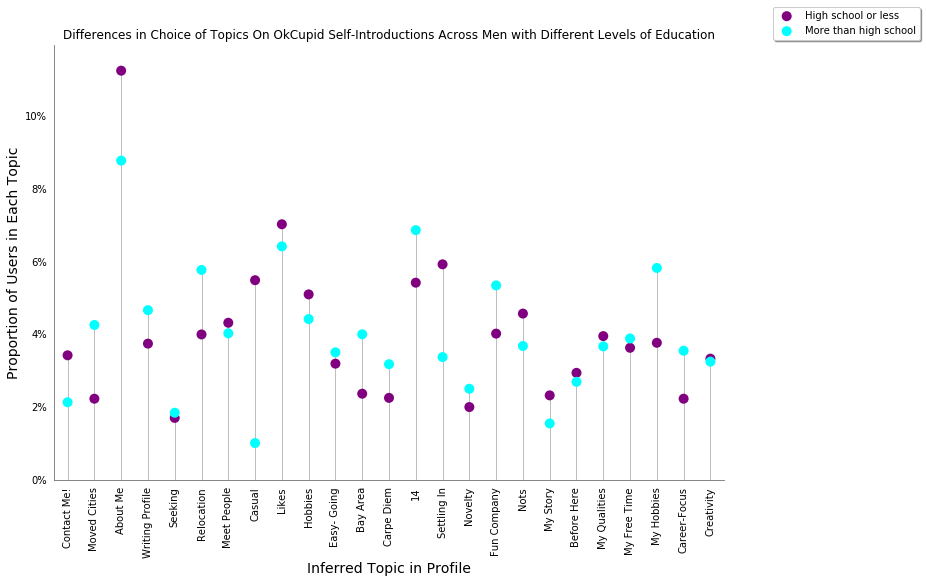

In [59]:
lollipop_chart(grouped, demog, colors=['Purple', 'Cyan'],topic_labels=labels)

### Section 2: Explaining the Visualization Choices

### Data and Objectives
The key overarching hypothesis to my research is that individuals present themselves differently across different situations and platforms depending on what they perceive to be desirable in that setting and their strategic goals from the social interaction. In the context of online dating, I am exploring whether men aim to increase their chances of finding a romantic partner specifically by ‘overcoming’ their perceived limitations in physical dimensions (such as height, weight and race) as well as education. 

If this trend were to be true for any of these variables, we would find a difference in the sub-categories thereof across the self-representations on these men’s profiles. Given the limitations of the available data (see ‘Initial Results’ PDF for more details), we focus on the ‘About Me’ self-introduction and apply topic modelling to assess for strategic choices of language and branding for self-representation.

In this particular visualization, our variable of choice is that of education. I have used the completion of a high school diploma as a cut off point for ‘low’ or ‘high’ education. This is based on earning prospects observed above and below the threshold by the US Bureau of Labour Statistics (Torpey, 2018). Subsequent research can build more categories separately for undergraduate and post-graduate studies.

If this trend were to be true for any of these variables, we would find a difference in the sub-categories thereof across the self-representations on these men’s profiles. Given the limitations of the available data (see ‘Initial Results’ PDF for more details), we focus on the ‘About Me’ self-introduction and apply topic modelling to assess for strategic choices of language and branding for self-representation.

In this particular visualization, our variable of choice is that of education. I have used the completion of a high school diploma as a cut off point for ‘low’ or ‘high’ education. This is based on earning prospects observed above and below the threshold by the US Bureau of Labour Statistics (Torpey, 2018). Subsequent research can build more categories separately for undergraduate and post-graduate studies. 


### Graphical Form
We have three variables at play- 
#### Qualitative/ Categorical:
•	The topics derived from the model (and labelled by the human user)
•	The sub-categories of the variable of interest. Here, we have ‘High School or Less’ versus ‘More than High Score’) 
#### Quantitative:
•	The proportion of users whose self-introductions include the given topic. 
Given these characteristics, some natural candidates for the form of the visualization would include grouped bar charts. However, with 25 topics, this would lead to 50 separate bars (one pair for each of the topics), which would render the graph cramped and unreadable. 
Instead, we could use some kind of stacking of the two categories on top of each other, so as to conserve space and maintain the aesthetic of the visualization. The challenge is that this could potentially affect the functionality and truthfulness of the graph. The result would resemble a stacked bar chart- giving the false impression that we are dividing one topic among the two categories. The intension is to highlight differences in the proportions, which may be lost with that particular format. 

Given these constraints, the best alternative appeared to be the lollipop chart.

### Color
As such, any colours could have been used. I chose cyan and purple as they add to the aesthetic appeal of the visualization, without confusing the meaning. 
It may have been possible to use different colours for the entire lollipop on each category. However, this would have created clutter. So I only applied the colour change at the ‘head’ of each lollipop. The ‘stick’ line was kept a light shade, so as to keep the overall structure clear, but not district from the more important encoding of colour. 

### Scale
We are now seeking to assess differences in qualitative proportions. Since there are 25 different topics, the percentage of users for any one topic is low. In the data, this never exceeds 18%. Thus, if we were to use the whole range of percentage values, the results would be squashed into the bottom corner. Therefore, we focus only on the first 0 to 20% range so that the finer differences can be more easily discerned. This does not affect the truthfulness of the visualization (our goal was never to highlight the dominance of one topic over another). At the same time, it maintains the insight, aesthetics and functionality. 

### Spatial Positioning
The topics could have been spaced on the y axis. However, I felt that one category scored 'more' than the other is better communicated by its marker being on top of- rather than to the right of- the other category's marker. Hence, the topics are placed on the x axis. 

### Story and Communications
The key story- and intriguing insight is that for the most part, the topics that both educated and less educated use in their self-descriptions roughly similar. 
There do exist some notable differences. More users with limited education emphasize aspects of fun, living in the moment and casualness (relative to those with more than a High School Diploma). But surprisingly, the latter show a markedly higher use of the ‘enthusiasm’ and ‘meet and greet’ topics- suggesting more excitement and interest in meeting new people without representing themselves as exciting company.  
Arranging the topics in this order, using clear colour distinctions and a lollilop chart all aim to emphasize these distinctions without a sense of visual overload. 


### REFERENCES
Torpey, Elka, 2018. ‘Measuring the Value of Education’, US Bureau of Labour Statistics. Retrieved from:  https://www.bls.gov/careeroutlook/2018/data-on-display/education-pays.htm 
